In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


Predicting using validation folder n16
Model reached train loss of 0.3922851085662842 and val loss of 0.4244135239718629
Loaded state dict from file


Text(0, 0.5, 'Error')

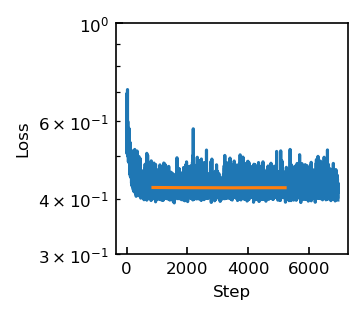

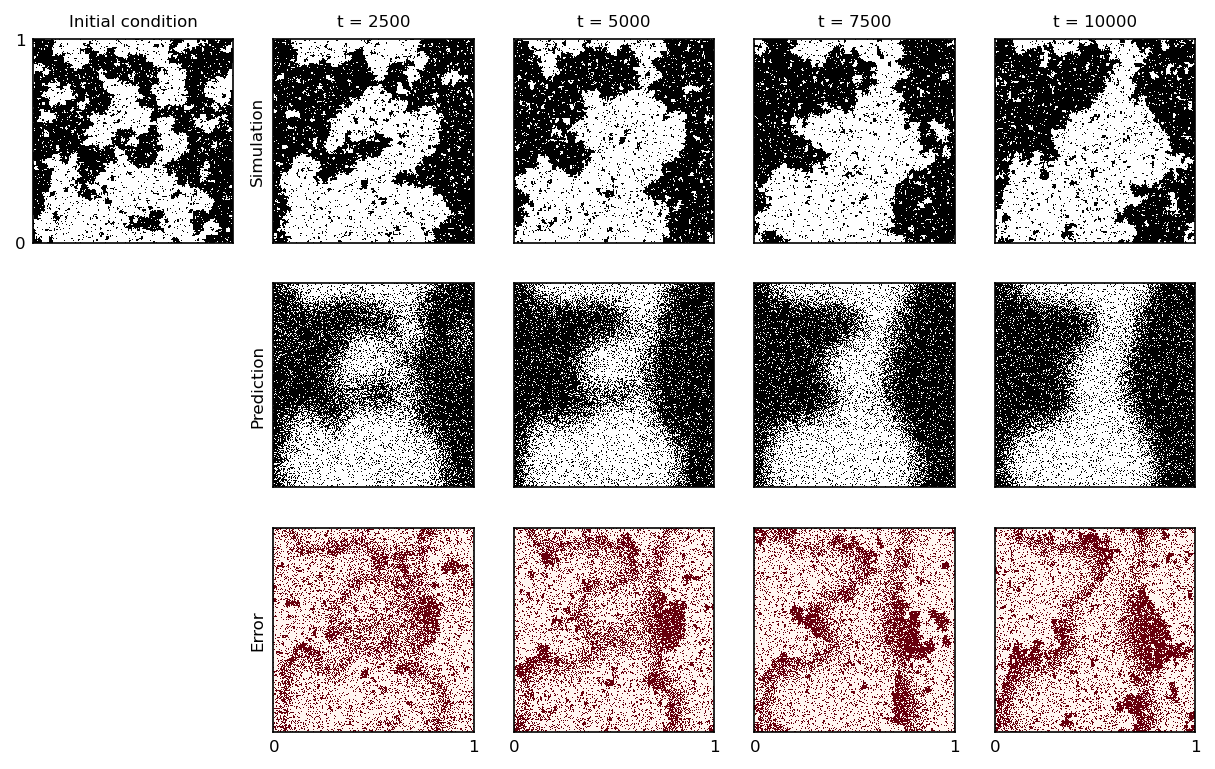

In [44]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting
from pprint import pprint

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_0'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
ds = SimulationDataset(folder, seq_len=25)

val_set_size = len(info['val_folder']) * 193 / 2

# Load model
info = torch.load(f'{model_path}.ckpt')
info["val_loss"] = np.array(info["val_loss"]) / val_set_size
print(f'Model reached train loss of {np.min(info["train_loss"])} and val loss of {np.min(info["val_loss"])}')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

val_step = np.arange(1, len(info["val_loss"]) + 1) * val_set_size

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(2, 2))
ax.plot(info["train_loss"])
ax.plot(val_step, info["val_loss"])
ax.tick_params(which='both', direction='in')
ax.set(xlabel='Step', ylabel='Loss', yscale='log', ylim=[3e-1, 1e0])

sample = ds[3]
with torch.no_grad():
    phi1 = model.simulate(sample['phi'][0:1].to(device), ds.seq_len)[0].detach().cpu().numpy().squeeze()

logits = 0.5 * (1 + phi1)
randoms = np.random.uniform(size=phi1.shape)
preds = np.zeros_like(phi1)
preds[randoms < logits] = 1
preds[randoms >= logits] = -1

plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8

fig, ax = plt.subplots(3, 5, figsize=(10, 6), dpi=150, sharex=True, sharey=True)
dt = 5
kwargs = dict(cmap='Greys', vmin=-1, vmax=1)
for i in range(5):
    ax[0,i].pcolormesh(sample['x'], sample['y'], sample['phi'][i*dt].squeeze(), **kwargs)
    if i > 0:
        ax[1,i].pcolormesh(sample['x'], sample['y'], preds[i*dt], **kwargs)

        err = np.abs(preds[i*dt] - sample['phi'][i*dt].squeeze().numpy())
        ax[2,i].pcolormesh(sample['x'], sample['y'], err, cmap='Reds', vmin=0, vmax=2)
        
        ax[0,i].set_title(f't = {i*dt*500}')        

ax[0,0].set_title('Initial condition')
ax[1,0].axis('off')
ax[2,0].axis('off')

for a in ax.flatten():
    a.set(xticks=[0, 1], yticks=[0, 1])
    a.tick_params(which='both', length=0)

ax[0,1].set_ylabel('Simulation')
ax[1,1].set_ylabel('Prediction')
ax[2,1].set_ylabel('Error')

## Calculate the saliencies using the validation dataset for each model

In [45]:
from tqdm.auto import tqdm

def compute_saliency(model, phi):
    '''
    Make predictions of the time derivative for each time point in sample
    Compute saliency using those predictions
    model is a neural network whose forward function predicts the time derivative
    phi is a [T, C, H, W] shaped FloatTensor which is a time series of occupation fractions
    '''
    loc = torch.zeros(phi.shape[-2:], dtype=phi.dtype, device=phi.device)
    G_S_sum = np.zeros(phi.shape[-2:])

    print(phi[0,0].cpu().numpy().shape)

    mask = np.ones(phi.shape[-2:], dtype=bool)
    nnz = np.asarray(np.nonzero(mask)).T
    for tt in tqdm(range(phi.shape[0])):
        G_S = []
        inputs = phi[tt:tt+1].clone()
        inputs.requires_grad = True
        dt_phi = model(inputs)

        # Select 100 random points to compute saliency
        np.random.shuffle(nnz)
        pts = nnz[:100]

        # print(loc.shape, pts)

        # Compute prediction saliency
        G_S = []
        for pt in pts:
            loc[:] = 0.
            loc[pt[0], pt[1]] = 1.

            grad = torch.autograd.grad(dt_phi[0,0],inputs, grad_outputs=loc, retain_graph=True)[0]
            G_S.append(grad.detach().cpu().numpy().squeeze())

        # Shift gradients to have common origin
        center = np.asarray([G_S[0].shape[-2]/2, G_S[0].shape[-1]/2]).astype(int)
        shifts = np.asarray(center-pts)
        G_S_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_S)])

        # Add to aggregated G_S_sum
        G_S_sum += np.sum(G_S_shifted, axis=0)
        
    return G_S_sum

for i in range(4):
    model_path = f'models/SimulationForecasting_{i}'
    
    # Load model
    info = torch.load(f'{model_path}.ckpt')
    model = SimulationForecasting().to(device)
    model.load_state_dict(info['state_dict'])
    model.eval();
    
    # Get validation set simulation
    with open(f'{model_path}_args.txt', 'r') as f:
        info = json.load(f)
    
        G_S_sum = 0
    
        for folder in np.random.choice(info['val_folder'], 1):
            ds = SimulationDataset(folder, seq_len=25)
    
            sample = ds[0]
            phi = sample['phi'].to(device)
            G_S_sum += compute_saliency(model, phi)
    
        np.save(f'{model_path}_saliency.npy', G_S_sum)

(256, 256)


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


(256, 256)


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


(256, 256)


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


(256, 256)


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


## Plot the saliencies

(256, 256)
[0.   0.01 0.01 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.05 0.06 0.06 0.07
 0.07 0.08 0.08 0.09 0.09 0.1  0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.14
 0.14 0.15 0.15 0.16 0.16 0.17 0.17 0.18 0.18 0.19 0.19 0.2  0.2  0.21
 0.21 0.22 0.22 0.23 0.23 0.24 0.24 0.25 0.25 0.26 0.26 0.27 0.27 0.28
 0.28 0.29 0.29 0.3  0.3  0.31 0.31 0.32 0.32 0.33 0.33 0.34 0.34 0.35
 0.35 0.36 0.36 0.37 0.37 0.38 0.38 0.39 0.39 0.4  0.4  0.41 0.41 0.42
 0.42 0.43 0.43 0.44 0.44 0.45 0.45 0.46 0.46 0.47 0.47 0.48 0.48 0.49
 0.49 0.5 ]
[-2.49e-01 -3.89e-02  3.14e-03  2.86e-03  2.73e-03  2.66e-03  2.32e-03
  1.67e-03  1.16e-03  1.05e-03  9.65e-04  7.92e-04  5.82e-04  4.29e-04
  3.11e-04  2.14e-04  1.33e-04  7.43e-05  3.83e-05  1.19e-05 -1.36e-06
 -9.71e-06 -1.28e-05 -1.23e-05 -1.18e-05 -1.23e-05 -1.19e-05 -1.10e-05
 -9.04e-06 -6.36e-06 -4.45e-06 -3.07e-06 -1.78e-06 -8.21e-07 -3.63e-07
 -1.96e-07 -1.30e-07 -4.36e-08 -1.68e-08 -3.92e-08 -3.51e-09  4.91e-08
  7.16e-08  5.23e-08  3.00e-08  2.02e-08  1.28e-08  8.

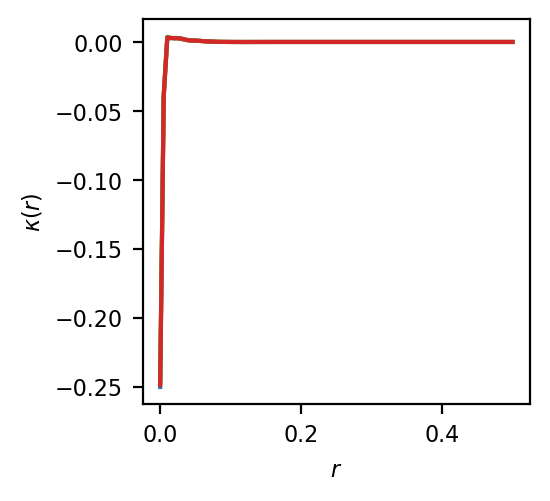

In [56]:
G_s = np.load(f'{model_path}_saliency.npy')
print(G_s.shape)

X = ds.x - np.mean(ds.x)
Y = ds.y - np.mean(ds.y)

def get_Gr(G_r, x=X , y=Y):
    G_r = G_r / np.abs(G_r).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
    r = np.linspace(0., np.max(rgrid) / np.sqrt(2), 100)
    dr = r[1] - r[0]
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(G_r[np.abs(rgrid - r[j]) <= dr])
        
    return r, gr

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2.5, 2.5))

for i in range(4):
    model_path = f'models/SimulationForecasting_{i}'
    G_s = np.load(f'{model_path}_saliency.npy')
    
    r, gr = get_Gr(G_s)
    ax.plot(r, gr)

ax.set(
    xlabel='$r$',
    ylabel='$\kappa(r)$'
)

print(r)
print(gr)